In [1]:
import sys
sys.path.append('/home/sakai/projects/Reimpl/HVQ-Trans/HVQ-Trans')
sys.path.append('./tools')

import argparse
import logging
import os
import pprint
import shutil
import time
import pandas as pd

import torch
import torch.distributed as dist
import torch.optim
import yaml
from datasets.data_builder import build_dataloader
from easydict import EasyDict
from tensorboardX import SummaryWriter
from torch.nn.parallel import DistributedDataParallel as DDP
from utils.criterion_helper import build_criterion
from utils.eval_helper import dump, log_metrics, merge_together, performances
from utils.lr_helper import get_scheduler
from utils.misc_helper import (
    AverageMeter,
    create_logger,
    get_current_time,
    load_state,
    save_checkpoint,
    set_random_seed,
)
from utils.optimizer_helper import get_optimizer
from utils.vis_helper import visualize_compound, visualize_single
from models.HVQ_TR_switch import HVQ_TR_switch
import wandb
from datetime import datetime

import numpy as np
from einops import rearrange
import matplotlib.pyplot as plt

In [5]:
config_path = "/home/sakai/projects/Reimpl/HVQ-Trans/HVQ-Trans/experiments/MVTec-LOCO/config.yaml"
ckpt_path = "/home/sakai/projects/Reimpl/HVQ-Trans/HVQ-Trans/experiments/MVTec-LOCO/checkpoints/HVQ_TR_switch/ckpt_best.pth.tar"
with open(config_path) as f:
    config = EasyDict(yaml.load(f, Loader=yaml.FullLoader))
    
model = HVQ_TR_switch(channel=384, embed_dim=64, n_embed=512)
model.eval()

checkpoint = torch.load(ckpt_path)

# Remove 'module.' prefix
new_state_dict = {key.replace("module.", ""): value for key, value in checkpoint['state_dict'].items()}

# Load the adjusted state dict
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [30]:
train_loader, val_loader = build_dataloader(config.dataset, distributed=False)

train_batches = list(train_loader)

In [56]:
# Training data
batch_idx = 1
sample_batch = train_batches[batch_idx]
with torch.no_grad():
    outputs = model(sample_batch)

print(outputs.keys())

dict_keys(['filename', 'height', 'width', 'label', 'clsname', 'clslabel', 'image', 'mask', 'feature_rec', 'feature_align', 'pred', 'pred_imgs', 'loss', 'feature_loss', 'latent_loss', 'id_list'])


In [78]:
def denormalize(x, mean, std):
    x = x * std + mean
    return x

def assign_colors_with_colormap(n, colormap='viridis'):
    # カラーマップの作成
    cmap = plt.get_cmap(colormap)
    
    # 0から1までの値に正規化
    norm = plt.Normalize(vmin=0, vmax=n-1)
    
    # 各整数に対してカラーマップから色を取得
    colors = [cmap(norm(i)) for i in range(n)]
    
    return colors

def plot_colored_array(img, arr, colormap='viridis'):
    
    # カラーマップを用いて配列を表示
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title("Original Image")
    
    ax[1].imshow(arr, cmap=colormap)
    ax[1].axis('off')
    ax[1].set_title("Code prediction")

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


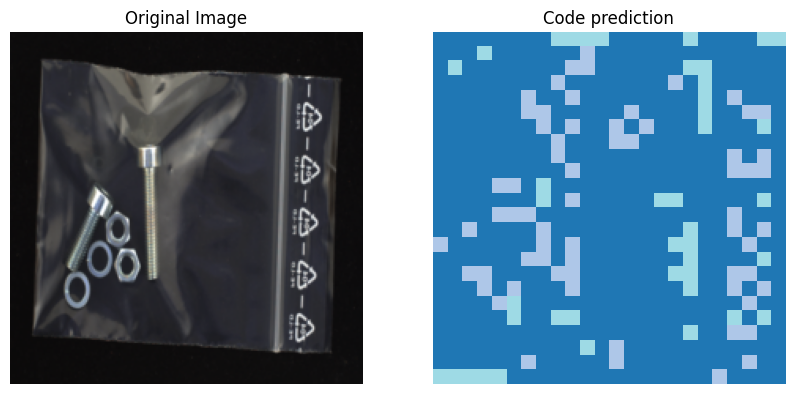

In [77]:
id_list = outputs["id_list"]  # (num_blocks, batch_size, num_tokens)
imgs = sample_batch["image"]
block_id = 0
sample_id = 7
p = 24
n = 30

id_tensor = id_list[block_id][sample_id]  # (num_tokens,)
img = imgs[sample_id].permute(1, 2, 0).cpu().numpy()  # (3, H, W)
img = denormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Visualize the token IDs
id_map = rearrange(id_tensor, "(h w) -> h w", h=p, w=p)
id_np = id_map.cpu().numpy()

plot_colored_array(img, id_np, colormap='tab20')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


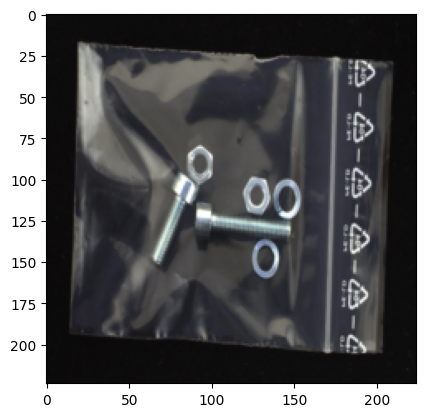

In [73]:
pred_imgs = outputs["pred_imgs"][sample_id]
pred_imgs = pred_imgs.cpu().permute(1, 2, 0).numpy()
pred_imgs = denormalize(pred_imgs, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
plt.imshow(pred_imgs)

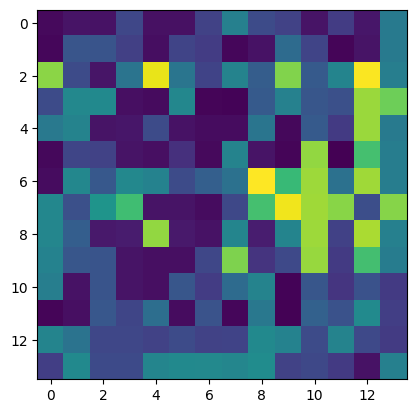

In [91]:
feature_rec = outputs["feature_rec"][sample_id]
feature_rec = torch.mean(feature_rec, dim=0)
feature_rec = feature_rec.cpu().numpy()

plt.imshow(feature_rec)